# Classifying multi-label comments

-------------------

## Importing libraries and Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
import emoji
from nltk.tokenize import word_tokenize
import cudf
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    %matplotlib inline
except:
    %matplotlib widget

In [3]:
train_df = pd.read_csv('../input/train.csv')

--------------------

## Exploratory Data Analysis (EDA)

In [4]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
18226,3022b1d01e513dbf,"""\nOppose. Not all of this published material ...",0,0,0,0,0,0
110389,4e8a68d1d7b15abb,"while you were screwing your pooch, my pooch w...",1,0,0,0,0,0
158504,eef4d4eb682a02c9,[Both posted before the #request by Gnan/garra...,0,0,0,0,0,0
121304,890cf8a350ea2d92,"""\n\nConflation of the two """"brook"""" homonyms\...",0,0,0,0,0,0
1842,04fb04b4870e8918,"""\n\nSure, here: No personal attacks, Don't mi...",0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [5]:
# checking null values
train_df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

There are no missing values

## Let's Check duplicacy 

In [6]:
train_df[train_df.duplicated(subset='comment_text') == True]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


there is no duplicacy 

## Setting target Columns 

In [7]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

## Extracting some basic features

* length_comment_text
* number of words in comment_text

In [8]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
train_df['num_words'] = train_df['comment_text'].apply(lambda x: len(list(str(x).strip().split(' '))))

In [9]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [10]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

## Checking Class Imbalance 

In [11]:
# let's see the total rows in train data and the numbers for the various categories
total_rows = len(train_df)
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [12]:
values = list(train_df[cols_target].sum())
target = cols_target

In [13]:
values.append(total_rows)
target.append('Neutral')

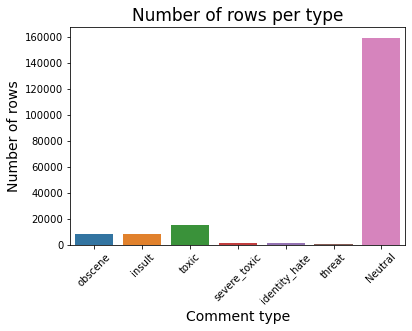

In [14]:
ax = sns.barplot(target, values)
ax.set_xticklabels(target, rotation=45)
ax.set_title('Number of rows per type', fontsize=17)
ax.set_ylabel('Number of rows', fontsize=14)
ax.set_xlabel('Comment type', fontsize=14);

#### There is a huge class Imbalance which will reduce the f1Score

### Checking Correlation

In [15]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [16]:
data = train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

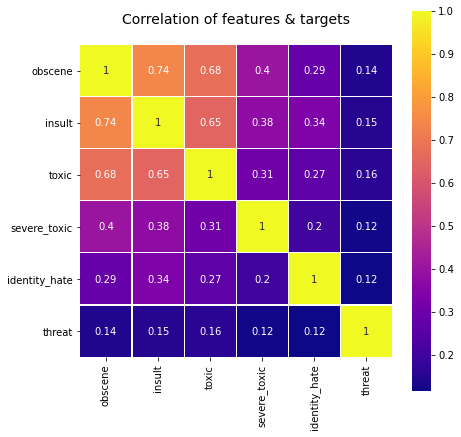

In [17]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?

Text(0.5, 1.0, 'Train')

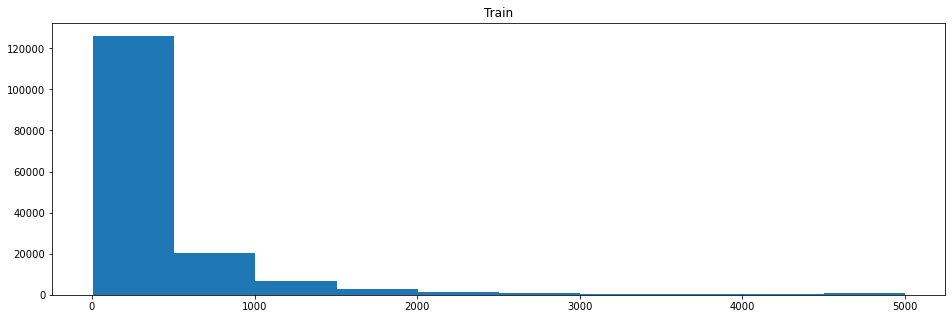

In [18]:
plt.figure(figsize=(16,5))
plt.hist(train_df['char_length'])
plt.title('Train')

--------------------------

## Clean up the comment text

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [20]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

-------------------


## Define X from entire train data for use in tokenization by Vectorizer

In [21]:
train_df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length,num_words
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,264,42
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,112,18


In [22]:
X = train_df.comment_text

In [23]:
print(X.shape)

(159571,)


## Vectorize the data

In [24]:
STOPWORDS = list(STOPWORDS)

In [25]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english', ngram_range=(1,3), dtype=np.float32)
vect

TfidfVectorizer(dtype=<class 'numpy.float32'>, max_features=5000,
                ngram_range=(1, 3), stop_words='english')

In [26]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)

In [27]:
X_dtm = X_dtm.toarray()
X_dtm = pd.DataFrame(X_dtm)

In [28]:
X_dtm['char_length'] = train_df['char_length']
X_dtm['num_words'] = train_df['num_words']

---------------------

## Splitting in train and test set 

In [29]:
x_train_validation, x_test, y_train_validation, y_test = train_test_split(X_dtm, train_df[cols_target], test_size=0.2, random_state=0)

In [30]:
x_train_validation.shape, y_train_validation.shape

((127656, 5002), (127656, 6))

## Further splitting the data into train and validation 

In [31]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_validation, y_train_validation, test_size=0.25, random_state=0)

In [32]:
total_rows = train_df.shape[0]

In [33]:
print('x_train,           x_validation,       x_test')
print(x_train.shape[0]/total_rows, x_validation.shape[0]/total_rows, x_test.shape[0]/total_rows)

x_train,           x_validation,       x_test
0.5999962399182809 0.19999874663942696 0.20000501344229216


----------------------------------------------------------------------------------------------------

## Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

As our data has lots of correlation we will use Classifier Chains

## Classifier Chains

In [34]:
# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [35]:
def plot_scores(values):
    
    mean_accuracy_train = []
    mean_accuracy_validation = []
    mean_accuracy_test = []
    
    mean_f1score_train = []
    mean_f1score_validation = []
    mean_f1score_test = []
    
    for count, i in enumerate(values):
        
        mean_accuracy = 0
        mean_f1score = 0
        number = 1
        
        for accuracy, f1score in i:
            
            if count == 0:
                mean_accuracy = (mean_accuracy + accuracy)/number
                mean_accuracy_train.append(mean_accuracy)
                mean_f1score = (mean_f1score + f1score)/number
                mean_f1score_train.append(mean_f1score)
                
            if count == 1:
                mean_accuracy = (mean_accuracy + accuracy)/number
                mean_accuracy_validation.append(mean_accuracy)
                mean_f1score = (mean_f1score + f1score)/number
                mean_f1score_validation.append(mean_f1score)
                
            if count==2:
                mean_accuracy = (mean_accuracy + accuracy)/number
                mean_accuracy_test.append(mean_accuracy)
                mean_f1score = (mean_f1score + f1score)/number
                mean_f1score_test.append(mean_f1score)
            
            number = 2
    
                
    plt.figure(figsize=(14,8))
    plt.suptitle('Mean Scores after each processed label', fontsize=20)
    
    ax1 = plt.subplot(1,2,1)
    ax1.plot(cols_target, mean_accuracy_train, label='train')
    ax1.plot(cols_target, mean_accuracy_validation, label='validation')
    ax1.plot(cols_target, mean_accuracy_test, label='test')
    ax1.legend()
    ax1.set_xticklabels(cols_target, rotation=45)
    ax1.set_title('Accuracy')
    
    ax2 = plt.subplot(122, sharey=ax1)
    ax2.plot(cols_target, mean_f1score_train, label='train')
    ax2.plot(cols_target, mean_f1score_validation, label='validation')
    ax2.plot(cols_target, mean_f1score_test, label='test')
    ax2.legend()
    ax2.set_xticklabels(cols_target, rotation=45)
    ax2.set_title('F1Score');
    
    
    plt.show()

In [36]:
def chain_classifier(model, x_train, y_train, x_validation=None, y_validation=None, 
                     x_test=None, y_test=None, validate=False, test=False, display=False, plot=False):

    print('Model = ', model, '\n')
    train_scores = []
    validation_scores = []
    test_scores = []
    
    for label in cols_target:

        print('... Processing {} \n'.format(label))
        
        y_train_label = y_train[label]
        y_validation_label = y_validation[label]
        y_test_label = y_test[label]
        
        # train the model using x_train & y_train
        model.fit(x_train,y_train_label)
        
        # compute the training results
        y_train_pred = model.predict(x_train)
        
        if display:
            print('Training Accuracy is {}'.format(accuracy_score(y_train_label, y_train_pred)))
            print('Training F1Score is {} \n'.format(f1_score(y_train_label, y_train_pred)))
        
        # Append scores
        to_append = (accuracy_score(y_train_label, y_train_pred), f1_score(y_train_label, y_train_pred))
        train_scores.append(to_append)
        
        # Adding predictions as features
        x_train = add_feature(x_train, y_train_pred)
        
        if validate:
            # compute validation results
            y_validation_pred = model.predict(x_validation)
            
            if display:
                print('Validation Accuracy is {}'.format(accuracy_score(y_validation_label, y_validation_pred)))
                print('Validation F1Score is {} \n'.format(f1_score(y_validation_label, y_validation_pred)))
            
            # Adding prediction as feature
            x_validation = add_feature(x_validation, y_validation_pred)
            
            
            # Append scores
            to_append = (accuracy_score(y_validation_label, y_validation_pred), f1_score(y_validation_label, y_validation_pred))
            validation_scores.append(to_append)

        if test:
            # compute test results
            y_test_pred = model.predict(x_test)
            
            if display:
                print('Test Accuracy is {}'.format(accuracy_score(y_test_label, y_test_pred)))
                print('Test F1Score is {} \n'.format(f1_score(y_test_label, y_test_pred)))
            
            # append Scores
            to_append = (accuracy_score(y_test_label, y_test_pred), f1_score(y_test_label, y_test_pred))
            test_scores.append(to_append)
            
            # Adding prediction as feature
            x_test = add_feature(x_test, y_test_pred)
        
    
    if plot:
        scores = (train_scores, validation_scores, test_scores)
        plot_scores(scores)
        
    return

----------------

## Building a simple XGBoost model 

In [37]:
xgb = XGBClassifier(tree_method = 'gpu_hist', gpu_id=0)

Model =  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=0, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None) 

... Processing obscene 

Training Accuracy is 0.9849595788682083
Training F1Score is 0.8434442270058709 

Validation Accuracy is 0.979946105157611
Validation F1Score is 0.7845117845117845 

Test Accuracy is 0.9781294062353125
Test F1Score is 0.770997375328084 

... Processing insult 

Training Accuracy is 0.9787240709406531
Training F1Score is 0.766639

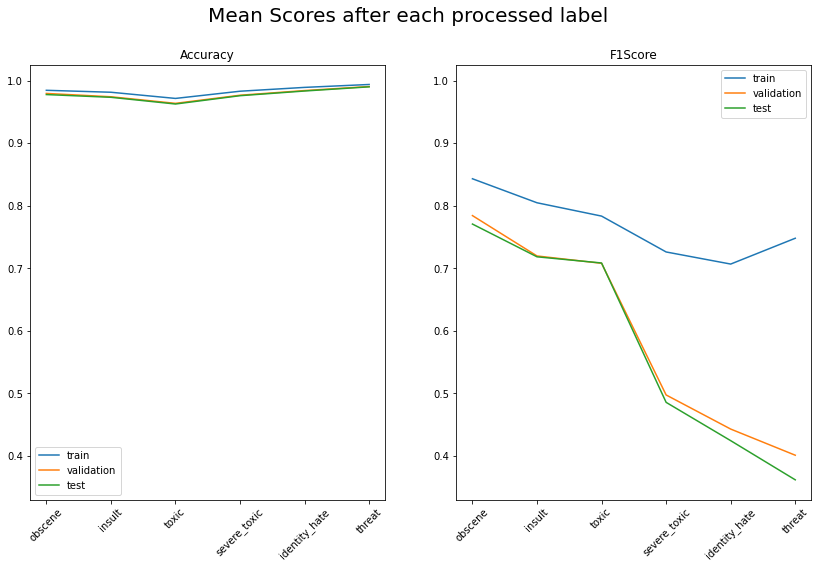

In [38]:
chain_classifier(xgb, x_train, y_train, x_validation, y_validation, x_test, y_test, validate=True, test=True, plot=True, display=True)

#### This is a direct result of highly imbalanced Data.

--------------------------------